# import librairies

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.linalg import cholesky, cho_solve
from scipy.stats import rdist
from sklearn.metrics import mean_squared_error, r2_score

/home/nash/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:53: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


# truncated Gaussian covariance 

In [2]:
# define eigenvalues
def eigenv_gaussian(j, e):
    A = math.pow(e,2*(j-1))
    B = math.pow(0.5*(1+np.sqrt(1+4*e*e))+e*e,j-1/2)
    return A/B

# define eigenfunctions
def eigenf_gaussian(j, e, t):
    A = np.sqrt(math.pow(1+4*e*e,1/4)/(2**(j-1)*math.factorial(j-1)))
    B = np.exp(-2*e*e*t*t/(1+np.sqrt(1+4*e*e)))
    C = scipy.special.eval_hermite(j-1,(1+4*e*e)**(1/4)*t )
    return A*B*C

# construct the truncated covariance function of order NT
def GaussianCovariance(e, t, u, NT):
    A = np.zeros((t.size,u.size))
    for k in range(1, NT+1):
        A += eigenv_gaussian(k,e)*np.multiply(eigenf_gaussian(k,e,t).reshape((t.size,1)),eigenf_gaussian(k,e,u).reshape((1, u.size)))
    return A

# derivative of truncated Gaussian covariance w.r.t to the parameter e 

In [3]:
# define the derivative of eigenvalues 
def deigenv_gaussian(j, e):
    D = 0.5*(1+np.sqrt(1+4*e*e))+e*e
    A = 2*(j-1)*np.float_power(e,2*(j-1)-1)-np.float_power(e,2*(j-1))*(j-0.5)/D*(2*e*(1+4*e*e)**(-0.5)+2*e)
    B = np.float_power(D, j-0.5)
    return A/B

# define the derivative of eigenfunctions 
def deigenf_gaussian(j,e,t):
    A1 = np.float_power(1+4*e*e,1/4)/(np.float_power(2, j-1)*scipy.special.factorial(j-1))
    A2 = A1**(-0.5)*e*(1+4*e*e)**(-3/4)/(2**(j-1)*scipy.special.factorial(j-1) )
    A = A1**(0.5)
    B = np.exp(-2*e*e*t*t/(1+np.sqrt(1+4*e*e)))
    B1 = 1+np.sqrt(1+4*e*e)
    B2 = -2*B*(2*e*t*t*B1-e*e*t*t*4*e*(1+4*e*e)**(-0.5))/B1**2
    C = scipy.special.eval_hermite(j-1,(1+4*e*e)**(1/4)*t )
    if j>1:
        C1 = 2*(j-1)*t*2*e*(1+4*e*e)**(-3/4)*scipy.special.eval_hermite(j-2,(1+4*e*e)**(1/4)*t )
    else:
        C1 = 0
    return (A2*B*C+A*B2*C+A*B*C1)

# construct the derivative of truncated covariance function of order NT 
def DerivativeCovariance(e, t, u, NT):
    A = np.zeros((t.size,u.size))
    for k in range(1, NT+1):
        A += deigenv_gaussian(k,e)*np.multiply(eigenf_gaussian(k,e,t).reshape((t.size,1)),eigenf_gaussian(k,e,u).reshape((1,u.size)))
        A += eigenv_gaussian(k,e)*np.multiply(deigenf_gaussian(k,e,t).reshape((t.size,1)),eigenf_gaussian(k,e,u).reshape((1,u.size)))
        A += eigenv_gaussian(k,e)*np.multiply(eigenf_gaussian(k,e,t).reshape((t.size,1)),deigenf_gaussian(k,e,u).reshape((1,u.size)))
    return A

# negative marginal log-likelihood 

In [4]:
def GaussianLoglikelihood(e, x, y, NT):
    Omega = GaussianCovariance(e, x, x, NT) + nugget*np.identity(x.size)
    L = cholesky(Omega, lower = True)
    A = 2*np.sum(np.log(np.diag(L))) 
    v = cho_solve((L, True), y.T)
    B = np.inner(y,v)
    return (A+B)/x.size

# derivative of negative marginal log-likelihood

In [5]:
def DerivativeLoglikelihood(e, x, y, NT):
    Omega = GaussianCovariance(e,x,x, NT) + nugget*np.identity(x.size)
    L = cholesky(Omega, lower = True)
    DerOmega = DerivativeCovariance(e, x, x, NT) 
    A = 0
    for i in range(0, x.size):
        u = cho_solve((L, True), [row[i] for row in DerOmega])
        A += u[i]
    v = cho_solve((L, True), y)
    B = np.dot(np.dot(v,DerOmega),v)
    return (A-B)/x.size

# Learning the shape parameter of the Gaussian covariance e

In [6]:
ALPHA = 0.01 
BETA = 0.02
MaxLoop = 50

def Optimize(e_0, x, y, NTT):
    
    def armijo(e, x, y, alpha, NT):
        grad = DerivativeLoglikelihood(e, x, y, NT)
        A = GaussianLoglikelihood(e-alpha*grad, x, y, NT) - GaussianLoglikelihood(e, x, y, NT)
        B = -1*ALPHA*alpha*(grad**2)
        res = A > B
        if (e-alpha*grad < 0):
            res = True
        return res
        
    def backtrack(e, x, y, NT):
        eps = 1
        i = 1
        while armijo(e,x,y,eps, NT) and i < MaxLoop:
            eps = BETA*eps 
            i +=1
        if i == MaxLoop:
            eps = 0
        return eps

    res = GaussianLoglikelihood(e_0, x, y, NTT)
    flag = True
    i = 1
    e = e_0
    while flag and i < MaxLoop+50:
        stepsize = backtrack(e, x, y, NTT)
        grad = DerivativeLoglikelihood(e,x,y,NTT)
        e -= stepsize*grad
        nres = GaussianLoglikelihood(e,x,y,NTT)
        if nres < res - 10**(-5):
            flag = True
        else:
            flag = False 
        res = nres
        i+=1
    return e

# Example

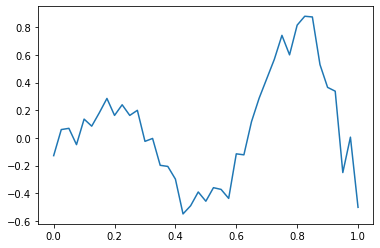

In [7]:
def True_function(x):
    return np.squeeze(x * np.sin(10*x))

nobs= 41 
ntest=101
x_obs = np.linspace(0,1,nobs) 
nugget = 1*10**(-1)
y_obs = True_function(x_obs) + np.random.normal(scale=nugget,size=nobs) # scale=noise std

x_predict = np.linspace(0,1,ntest) 
data_array = True_function(x_predict)
plt.plot(x_obs ,y_obs)
plt.show()

x_data, y_data = x_obs, y_obs

# find the optimal shape parameter e

In [8]:
e_0 = 20 # initial parameter
N_gaussian = 30 # truncation order

e = Optimize(e_0, x_data, y_data, N_gaussian)
print('the optimal shape parameter is:',e)

the optimal shape parameter is: 18.931743769934876


# find the mean and the std prediction

In [9]:
def GaussianPredict(e, X, y,  Xtest, NT):
    if type(Xtest) == float:
        Xtest = np.array(Xtest)
    K_star = GaussianCovariance(e, X, Xtest, NT)
    K = GaussianCovariance(e, X,X, NT) + nugget*np.identity(X.size)

    L = np.linalg.cholesky(K )
    Lk = np.linalg.solve(L, K_star)
    mu = np.dot(Lk.T, np.linalg.solve(L, y))
    K_ = GaussianCovariance(e, Xtest, Xtest, NT) 
    sd = np.sqrt(np.diag(K_) - np.sum(Lk**2, axis=0))
    return (mu, sd)

y_gaussian, sd_gaussian = GaussianPredict(e, x_data, y_data, x_predict, N_gaussian)

# find different metrics for evaluation

In [10]:
Error = y_gaussian.reshape(data_array.shape) - data_array
SquareError = np.square(Error)
ISEGaussian = np.trapz(SquareError, dx = 1/(data_array.size-1))# dx/3 * np.sum(yMS[0:-1:2] + 4*yMS[1::2] + yMS[2::2])
MaxGaussian = np.max(np.absolute(Error))
LLGaussian = GaussianLoglikelihood(e, x_data, y_data, N_gaussian)
R2Gaussian = r2_score(data_array, y_gaussian)
MSEG = mean_squared_error(data_array, y_gaussian)
print('\t mean squared error=', MSEG)
print('\t log marginal likelihood=', LLGaussian)
print('\t R-squared=', R2Gaussian)

	 mean squared error= 0.002493884065299862
	 log marginal likelihood= -1.0450360587933474
	 R-squared= 0.9818565454102167


# Illustration

(-1.0, 1.0)

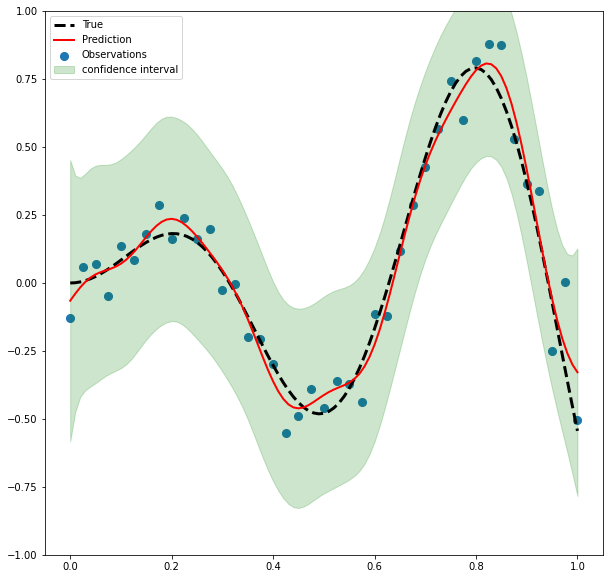

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(x_obs, y_obs,s=65, label="Observations")
plt.plot(x_predict, data_array, color='k', linewidth='3',label="True",linestyle='--')
plt.plot(x_predict, y_gaussian, color='red', linewidth = '2',label="Prediction")
plt.fill_between(
    x_predict.ravel(),
    y_gaussian - 1.96 * sd_gaussian,
    y_gaussian + 1.96 * sd_gaussian,color='green',
    alpha=0.2,
    label=r"confidence interval",
)
plt.legend(loc='upper left')
plt.ylim(-1, 1)